## Mod 1 Final Project Submission

* Students' names: Kayli Leung and Alec Morgan
* Students' pace: Full time
* Scheduled project review date/time: 04/19/2019 12:30 PM 
* Instructors' names: Miles Erickson, Greg Damico
* Blog post URL: TODO(Alec): Write blog.

## BUSINESS UNDERSTANDING

## Project Goals

For this project, we imagine ourselves as employees of a company such as Redfin or Zillow. Our goal is to build the most accurate price-estimating model possible, which in turn will help with our site's user retention. To this end we ask three questions:

* How accurately can we predict prices?
* How *consistently* can we maintain that accuracy?
* Can this accuracy be improved by targeting a majority percentile and thus ignoring outliers?

To this end we employ the CRISP-DM methodology: business understanding, data understanding, data preparation, modeling, evaluation, and deployment. 

## Import necessary modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from haversine import haversine
import scipy.stats as stats

### Loading the King County home sales data set

Here we load our data set: some 21,597 records of home sales in King County, WA from 2014 and 2015. There are 21 pieces of information in each record, each of which is explained briefly in `column_names.md`. A more detailed glossary of these and many more terms can be found at: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

In [2]:
house_data = pd.read_csv('kc_house_data.csv')

Our dataset is only 2.5 MBs, so we choose not to subsample it (since this step would only be necessary if it were too large to process efficiently in the first place). 

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## DATA UNDERSTANDING/PREPARATION

Here we remove and reformat invalid data entries so that we can have data our model is capable of working with. We also choose to remove some data features entirely due to their high collinearities--that is, being similar to each other as well as to the variable we're trying to predict (price). This way we prevent our model from erroneously believing, for example, that `zipcode` and `latitude` count twice when considering a house's value.

In [4]:
house_data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

454 entries list basement size as `?`. However, these same entries contain `sqft_living` and `sqft_above` values as well, and these often do not match. For columns in which `sqft_basement` is `?`, we reassign `sqft_basement` to `sqft_living` minus `sqft_above`. 

In [5]:
mask = house_data['sqft_basement'] == '?'
house_data.loc[mask, 'sqft_basement'] = (house_data['sqft_living'] - house_data['sqft_above'])
house_data[['sqft_basement', 'sqft_living', 'sqft_above']].head(10).T

,0,1,2,3,4,5,6,7,8,9
sqft_basement,0.0,400.0,0.0,910.0,0.0,1530.0,0,0.0,730.0,0.0
sqft_living,1180,2570,770,1960,1680,5420,1715,1060,1780,1890
sqft_above,1180,2170,770,1050,1680,3890,1715,1060,1050,1890


In [6]:
house_data['view'].isna().sum()

63

We have 63 `NaN` values for `view`. Since this is still not a large proportion of our observations, we choose to discard the afflicted rows. Our total entry count drops from 21,597 to 21,534. 

In [7]:
house_data = house_data.dropna(subset=['view'])
house_data['view'].isna().sum()

0

In [8]:
house_data['yr_renovated'].value_counts().head()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

16,961 of our entries have `yr_renovated` values of `0`. Fixing that would require making unsafe assumptions, so we elect to drop this column entirely instead. 

In [9]:
house_data = house_data.drop('yr_renovated', axis=1)

Due to their high collinearity with other variables, we choose to drop `zipcode`, `sqft_above`, and `sqft_living15`. Furthermore, we dropped `grade` because the documentation of the column showed that part of the grading system includes square footage as well as number of bathrooms, which suggests high collinearity (as reflected in the numbers).

In [10]:
house_data = house_data.drop('zipcode', axis=1)
house_data = house_data.drop('sqft_above', axis=1)
house_data = house_data.drop('sqft_living15', axis=1)
house_data = house_data.drop('grade', axis=1)

In [11]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 16 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       19164 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(7), object(2)
memory usage: 2.8+ MB


`waterfront` contains 2,370 `Null` values. We don't want to drop 2,370 entries, so we elect to replace these with `0` instead, since `0` is the most frequently occurring value for `waterfront`.

In [12]:
house_data = house_data.fillna(0)

Since `price` is our target variable, we want it to have a normal distribution--if not, it will be difficult to linearly model.

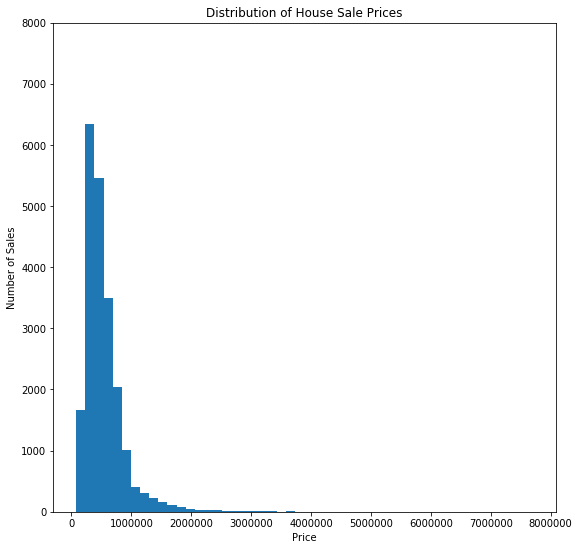

In [13]:
plt.figure(figsize=(9,9))
plt.ylim(0, 8000)
plt.xlabel('Price')
plt.ylabel('Number of Sales')
plt.title('Distribution of House Sale Prices')
_ = plt.hist(house_data['price'], bins=50)

Price is not normally distributed. However, a log transformation will rectify that.

In [14]:
house_data['log_price'] = house_data['price'].apply(lambda x: np.log(x))

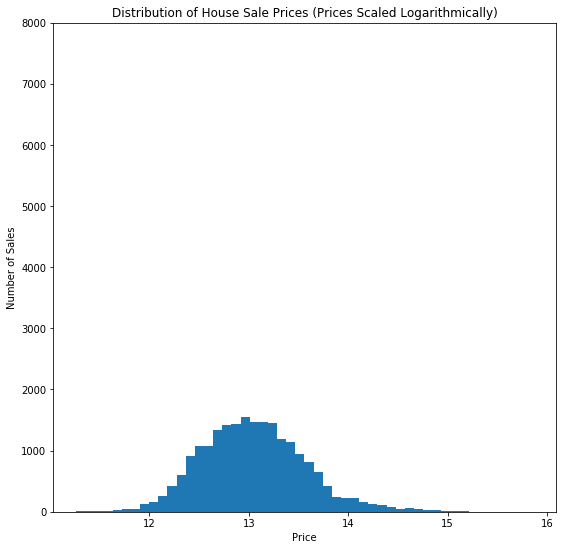

In [15]:
plt.figure(figsize=(9,9))
plt.ylim(0, 8000)
plt.xlabel('Price')
plt.ylabel('Number of Sales')
plt.title('Distribution of House Sale Prices (Prices Scaled Logarithmically)')
_ = plt.hist(house_data['log_price'], bins=50)

Okay, we just scrubbed a lot of data--how do the remaining columns correlate with each other?

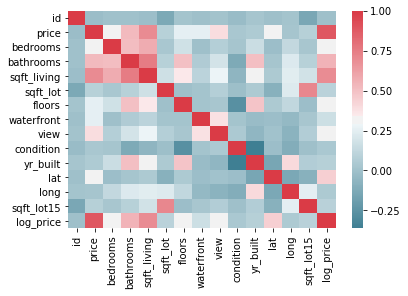

In [16]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(house_data.corr(), cmap=color_map)

Most of our highly collinear variables are gone, great! But our strongest remaining predictors (e.g. `bathrooms`, `bedrooms`, and `sqft_living`) still have high collinearity with each other. In spite of this we decide to leave them, and resolve to test our model carefully to get the best accuracy we can without too much overfitting.

At this point, it occurs to us that outliers in price may skew the rest of our predictions. We decide it's in the best interests of our site to predict property values more accurately for the majority of potential users, and to that end we subset our data to the bottom 90th, 95th, and 100th percentiles of price here. Later on we will test our models on all of these, concluding that with the 90th percentile subset we get significantly improved accuracy without noteworthy issues in model bias. 

In [17]:
price_90th_perc = np.percentile(house_data['log_price'], 90)
house_data_90 = house_data.drop(house_data[house_data['log_price'] > price_90th_perc].index)

price_95th_perc = np.percentile(house_data['log_price'], 95)
house_data_95 = house_data.drop(house_data[house_data['log_price'] > price_95th_perc].index)

house_data_100 = house_data

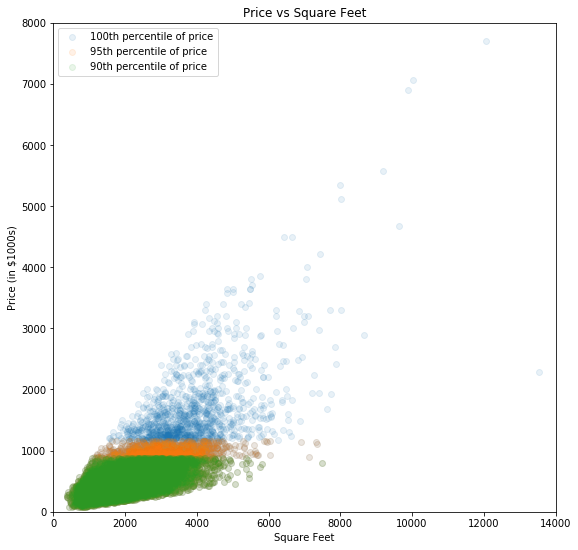

In [18]:
plt.figure(figsize=(9, 9))
plt.title('Price vs Square Feet')
plt.xlim(0, 14000)
plt.ylim(0, 8000)
plt.xlabel('Square Feet')
plt.ylabel('Price (in $1000s)')
_ = plt.scatter(house_data['sqft_living'], house_data['price']/1000, alpha=0.1, label='100th percentile of price')
_ = plt.scatter(house_data_95['sqft_living'], house_data_95['price']/1000, alpha=0.1, label='95th percentile of price')
_ = plt.scatter(house_data_90['sqft_living'], house_data_90['price']/1000, alpha=0.1, label='90th percentile of price')
plt.legend()
plt.show()

We also decided to engineer a distance from downtown Seattle feature, `distance_from_downtown_sea`, as we expect this to be a very strong predictor of house value. 

In [19]:
downtown_sea = (47.609795, -122.337173) #(lat, lon)

house_data_90['lat_long'] = list(zip(house_data_90['lat'], house_data_90['long']))
house_data_90['distance_from_downtown_sea'] = house_data_90['lat_long'].apply(lambda x: haversine(downtown_sea, x, unit='mi'))

What do the distributions of our 90th percentile features look like now?

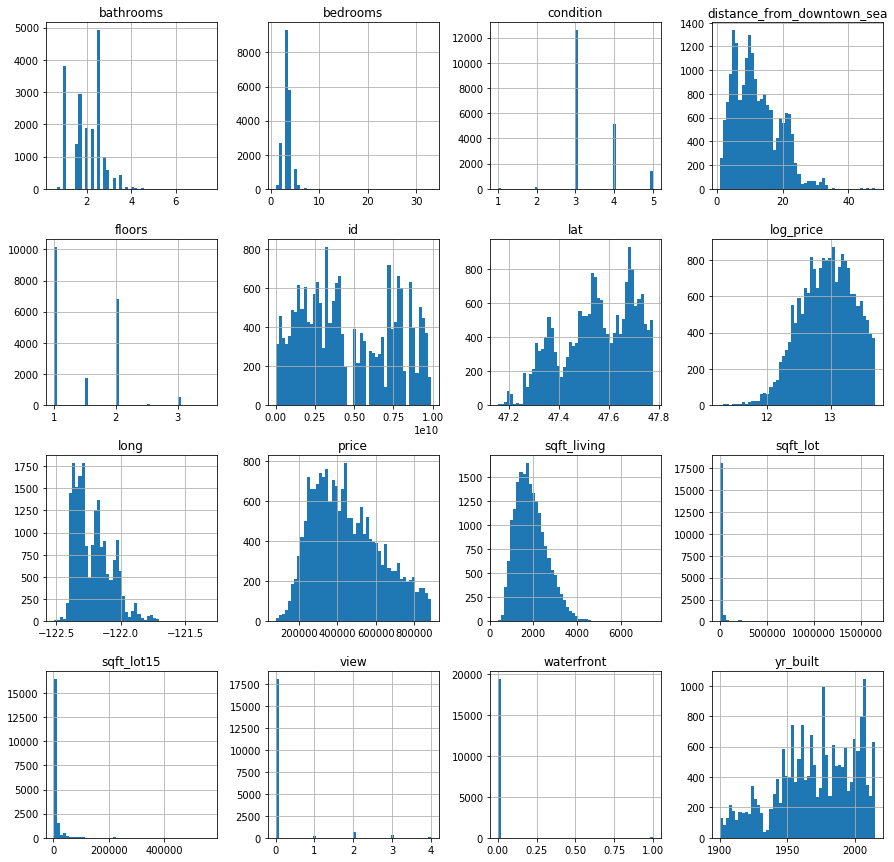

In [20]:
_ = house_data_90.hist(figsize=(15, 15), bins=50)

There's a lot going on here. None of these features have a normal distribution, and only some of them come close. We would certainly want to apply some normalizing transformations to these so that they could more accurately fit the assumptions made by linear regression. However, this is not feasible with the time constraints of this project, so we decide that this is good enough and we'll analyze this data in the state it's in now. 

## MODELING

Here we proceed to train and test a wide variety of models with a laser focus on our two main goals: accuracy and consistency.

### Simple Linear Regression

We start by running some simple linear regressions to see how individual features (e.g. square footage, number of bedrooms, etc) predict price. This will help us later when choosing features to use in conjunction for predicting price.

In [21]:
# Setting a seed for reproducibility purposes. 
np.random.seed(2019)

In [22]:
# get a simple linear regression model for price and sqft_living
x_90 = np.array(house_data_90['sqft_living']).reshape(-1,1)
y_90 = np.array(house_data_90['log_price'])

x_95 = np.array(house_data_95['sqft_living'])
y_95 = np.array(house_data_95['log_price'])

x_100 = np.array(house_data_100['sqft_living'])
y_100 = np.array(house_data_100['log_price'])

In [23]:
def simple_linear_model(predictor, target, df):
    """Provides model the simple linear regression model between a predictor and target"""
    x = predictor
    y = target
    formula = 'y~x'
    model = ols(formula=formula, data=df).fit()
    return model.summary()

Here we demonstrate that all of our simple linear regression models have p-values of under 0.05, thus demonstrating statistical significance. 

In [24]:
simple_linear_model(x_90, y_90, house_data_90)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     8791.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:29:26   Log-Likelihood:                -6843.5
No. Observations:               19381   AIC:                         1.369e+04
Df Residuals:                   19379   BIC:                         1.371e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3209      0.007   1754.994      0.000      12.307      12.335
x              0.0003   3.43e-06     93.762      0.000       0.000       0.000
==============================================================================
Omnibus:                      331.033   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.090
Skew:                          -0.194   Prob(JB):                     6.68e-56
Kurtosis:                       2.596   Cond. No.                     5.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
simple_linear_model(x_95, y_95, house_data_95)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                 1.210e+04
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:29:26   Log-Likelihood:                -7898.6
No. Observations:               20472   AIC:                         1.580e+04
Df Residuals:                   20470   BIC:                         1.582e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2907      0.007   1815.924      0.000      12.277      12.304
x              0.0003   3.18e-06    110.012      0.000       0.000       0.000
==============================================================================
Omnibus:                      218.199   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.214
Skew:                          -0.120   Prob(JB):                     9.83e-36
Kurtosis:                       2.637   Cond. No.                     5.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
simple_linear_model(x_100, y_100, house_data_100)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                 2.009e+04
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:29:26   Log-Likelihood:                -9635.4
No. Observations:               21534   AIC:                         1.927e+04
Df Residuals:                   21532   BIC:                         1.929e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2191      0.006   1911.738      0.000      12.207      12.232
x              0.0004   2.81e-06    141.753      0.000       0.000       0.000
==============================================================================
Omnibus:                        3.669   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                3.690
Skew:                           0.029   Prob(JB):                        0.158
Kurtosis:                       2.974   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we test the accuracy of our simple models using MAE (Median Absolute Error) as our metric of choice.

In [27]:
def test_median_err(predictors, target):
    """Train a model on the variables provided and return that model's MAE."""
    X = np.array(predictors)
    y = np.array(target)
    linreg = LinearRegression()
    test_err = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_test = linreg.predict(X_test)
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(y_test)
        test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    return np.mean(test_err)

In [28]:
sqft_living_mae_90 = test_median_err(x_90, y_90.reshape(-1,1))
sqft_living_mae_95 = test_median_err(x_95.reshape(-1,1), y_95.reshape(-1,1))
sqft_living_mae_100 = test_median_err(x_100.reshape(-1,1), y_100.reshape(-1,1))

print('MAE when predicting with  90th percentile:', sqft_living_mae_90)
print('MAE when predicting with  95th percentile:', sqft_living_mae_95)
print('MAE when predicting with 100th percentile:', sqft_living_mae_100)

MAE when predicting with  90th percentile: 106513.97415351053
MAE when predicting with  95th percentile: 111594.2202744179
MAE when predicting with 100th percentile: 116862.87098920054


The 90th percentile has the lowest MAE value and therefore it is easier to fit to the 90th percentile than to the 95th or 100th percentile of the data. 

Now we'll see how this early test model fits our data.

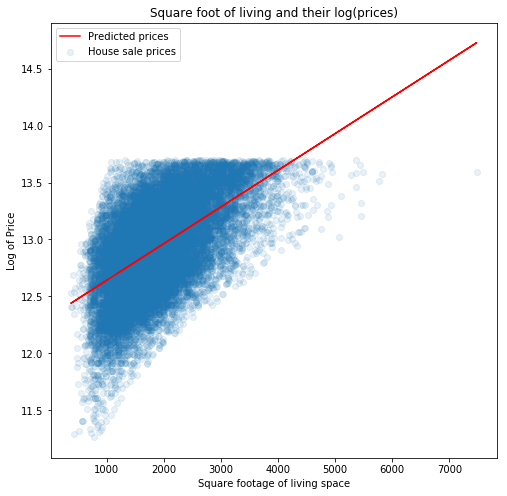

In [29]:
x_90 = house_data_90['sqft_living']
y_90 = house_data_90['log_price']
formula = 'y_90~x_90'
model = ols(formula=formula, data=house_data_90).fit()
y_hat_90 = model.predict()

plt.figure(figsize=(8,8))
plt.scatter(x_90,y_90, label='House sale prices', alpha = 0.1)
plt.plot(x_90, y_hat_90, color='red', label='Predicted prices')
plt.title('Square foot of living and their log(prices)')
plt.legend()
plt.xlabel('Square footage of living space')
plt.ylabel('Log of Price')
plt.show()

### Multivariable Linear Regression

Here we begin to attempt to predict price using multiple predictors simultaneously. 

In [30]:
predictors = house_data_90.columns
predictors = list(predictors)
predictors.remove('date')
predictors.remove('price')
predictors.remove('log_price')
predictors.remove('lat_long')

We want to get a preliminary idea of how useful certain predictors are likely to be. As a test, we run simple linear regression models with each predictor individually and log the resulting MAE values. The sorted list of MAE values gives us some idea of the usefulness of each predictor.

In [31]:
predictor_mae = {}
for predictor in predictors:
    x = house_data_90[[predictor]]
    y = house_data_90['log_price']
    predictor_mae[predictor] = test_median_err(x,y)

sorted_predictor_mae = sorted(predictor_mae.items(), key=lambda x :x[1])
sorted_predictor_mae

[('lat', 101128.02429054394),
 ('sqft_living', 106728.62071853229),
 ('distance_from_downtown_sea', 112840.04618446913),
 ('bathrooms', 115269.91847391214),
 ('sqft_basement', 121471.87330553246),
 ('view', 123871.26389317901),
 ('floors', 124056.86458271842),
 ('bedrooms', 124149.22135864905),
 ('long', 125616.59966481877),
 ('sqft_lot', 125645.63338567116),
 ('waterfront', 126108.62448969611),
 ('sqft_lot15', 126360.28779563338),
 ('id', 126890.64197101525),
 ('condition', 127191.8865425466),
 ('yr_built', 127462.04048024611)]

Here we create a function to create K-folds for use in cross validation. We will use cross validation to ensure that our model will fit our test sets and not just training sets. 

In [32]:
def kfolds(data, k):
    """Convert data to a dataframe and construct k-tolds for train-test"""
    # create a dataframe from the data
    df = pd.DataFrame(data)
    
    #find the number of rows in the data frame
    num_observations = len(df)
    
    # determine how large the folds are as well as how much leftover
    rows_in_folds = num_observations//k #floor division
    leftover_rows = num_observations%k
    
    folds = [] #make a list of fold sizes
    starting_row = 0  # start the fold at this row
    for i in range(k):
        if leftover_rows > 0:
            folds.append(df.iloc[starting_row : starting_row+rows_in_folds+1])
            leftover_rows -= 1
            starting_row += rows_in_folds + 1
        else:
            folds.append(df.iloc[starting_row : starting_row+rows_in_folds])
            starting_row += rows_in_folds
         
    return folds

This function runs K-fold cross validation on predictors and the target. We use median absolute error as our metric and inversely transform the log of price to get an actual price value.

In [33]:
def mae_for_kfolds(X, y, data, k):   #X is a list of predictor names. y is a list of the target name
    """Constructs an array of MAE values for k folds of data"""
    folds = kfolds(data, k) #constructs kfolds
    
    test_errs = []
    train_errs = []
    for n in range(k):
        # Split in train and test for the fold
        train = pd.concat([fold for i,fold in enumerate(folds) if i != n])
        test = folds[n]
        # Fit a linear regression model
        linreg = LinearRegression()
        test_err = []
        linreg.fit(train[X], train[y])
        #Evaluate Train and Test Errors
        y_hat_test = linreg.predict(test[X])
        y_hat_train = linreg.predict(train[X])
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(test[y])
        invert_y_hat_train = np.exp(y_hat_train)
        invert_y_train = np.exp(train[y])
        test_errs.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        train_errs.append(median_absolute_error(invert_y_train, invert_y_hat_train))
    return train_errs, test_errs

We will select which housing features to use by scikit-learn's feature selection tool. We will increase the number of features while we are satisfied with the MAE.

In [34]:
linreg = LinearRegression()
selector1 = RFE(linreg, n_features_to_select = 2)
selector1 = selector1.fit(house_data_90[predictors], house_data_90['log_price'])

In [35]:
sorted(list(zip(predictors, selector1.support_, selector1.ranking_)), key=lambda x: x[2])

[('waterfront', True, 1),
 ('lat', True, 1),
 ('bathrooms', False, 2),
 ('long', False, 3),
 ('view', False, 4),
 ('condition', False, 5),
 ('floors', False, 6),
 ('bedrooms', False, 7),
 ('distance_from_downtown_sea', False, 8),
 ('yr_built', False, 9),
 ('sqft_living', False, 10),
 ('sqft_basement', False, 11),
 ('sqft_lot', False, 12),
 ('sqft_lot15', False, 13),
 ('id', False, 14)]

In [36]:
X1 = ['waterfront', 'lat']
y = ['log_price']
cv_1 = mae_for_kfolds(X1, y, house_data_90, 20)
train_errors = cv_1[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_1[0], cv_1[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-89.01668133752173, 100898.57932824478)

In [37]:
selector2 = RFE(linreg, n_features_to_select = 3)
selector2 = selector2.fit(house_data_90[predictors], house_data_90['log_price'])

sorted(list(zip(predictors, selector2.support_, selector2.ranking_)), key=lambda x: x[2])

[('bathrooms', True, 1),
 ('waterfront', True, 1),
 ('lat', True, 1),
 ('long', False, 2),
 ('view', False, 3),
 ('condition', False, 4),
 ('floors', False, 5),
 ('bedrooms', False, 6),
 ('distance_from_downtown_sea', False, 7),
 ('yr_built', False, 8),
 ('sqft_living', False, 9),
 ('sqft_basement', False, 10),
 ('sqft_lot', False, 11),
 ('sqft_lot15', False, 12),
 ('id', False, 13)]

In [38]:
X2 = ['bathrooms','waterfront', 'lat']
cv_2 = mae_for_kfolds(X2, y, house_data_90, 20)

train_errors = cv_2[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_2[0], cv_2[1]))]
np.mean(error_diffs), np.mean(train_errors)

(85.48395938457107, 84786.4716809472)

In [39]:
selector3 = RFE(linreg, n_features_to_select = 4)
selector3 = selector3.fit(house_data_90[predictors], house_data_90['log_price'])

sorted(list(zip(predictors, selector3.support_, selector3.ranking_)), key=lambda x: x[2])

[('bathrooms', True, 1),
 ('waterfront', True, 1),
 ('lat', True, 1),
 ('long', True, 1),
 ('view', False, 2),
 ('condition', False, 3),
 ('floors', False, 4),
 ('bedrooms', False, 5),
 ('distance_from_downtown_sea', False, 6),
 ('yr_built', False, 7),
 ('sqft_living', False, 8),
 ('sqft_basement', False, 9),
 ('sqft_lot', False, 10),
 ('sqft_lot15', False, 11),
 ('id', False, 12)]

In [40]:
X3 = ['bathrooms','waterfront', 'lat', 'long']
cv_3 = mae_for_kfolds(X3, y, house_data_90, 20)
train_errors = cv_3[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_3[0], cv_3[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-160.25887656637786, 83979.74497321206)

In [41]:
selector4 = RFE(linreg, n_features_to_select = 5)
selector4 = selector4.fit(house_data_90[predictors], house_data_90['log_price'])

sorted(list(zip(predictors, selector4.support_, selector4.ranking_)), key=lambda x: x[2])

[('bathrooms', True, 1),
 ('waterfront', True, 1),
 ('view', True, 1),
 ('lat', True, 1),
 ('long', True, 1),
 ('condition', False, 2),
 ('floors', False, 3),
 ('bedrooms', False, 4),
 ('distance_from_downtown_sea', False, 5),
 ('yr_built', False, 6),
 ('sqft_living', False, 7),
 ('sqft_basement', False, 8),
 ('sqft_lot', False, 9),
 ('sqft_lot15', False, 10),
 ('id', False, 11)]

In [42]:
X4 = ['bathrooms','waterfront', 'view', 'lat', 'long']
cv_4 = mae_for_kfolds(X4, y, house_data_90, 20)
train_errors = cv_4[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_4[0], cv_4[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-169.7818602270774, 81535.2172927552)

In [43]:
selector5 = RFE(linreg, n_features_to_select = 6)
selector5 = selector5.fit(house_data_90[predictors], house_data_90['log_price'])

sorted(list(zip(predictors, selector5.support_, selector5.ranking_)), key=lambda x: x[2])

[('bathrooms', True, 1),
 ('waterfront', True, 1),
 ('view', True, 1),
 ('condition', True, 1),
 ('lat', True, 1),
 ('long', True, 1),
 ('floors', False, 2),
 ('bedrooms', False, 3),
 ('distance_from_downtown_sea', False, 4),
 ('yr_built', False, 5),
 ('sqft_living', False, 6),
 ('sqft_basement', False, 7),
 ('sqft_lot', False, 8),
 ('sqft_lot15', False, 9),
 ('id', False, 10)]

In [44]:
X5 = ['bathrooms','waterfront', 'view', 'condition', 'lat', 'long']
cv_5 = mae_for_kfolds(X5, y, house_data_90, 20)
train_errors = cv_5[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_5[0], cv_5[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-247.6931834416624, 80757.98259279769)

In [45]:
selector6 = RFE(linreg, n_features_to_select = 7)
selector6 = selector6.fit(house_data_90[predictors], house_data_90['log_price'])

sorted(list(zip(predictors, selector6.support_, selector6.ranking_)), key=lambda x: x[2])

[('bathrooms', True, 1),
 ('floors', True, 1),
 ('waterfront', True, 1),
 ('view', True, 1),
 ('condition', True, 1),
 ('lat', True, 1),
 ('long', True, 1),
 ('bedrooms', False, 2),
 ('distance_from_downtown_sea', False, 3),
 ('yr_built', False, 4),
 ('sqft_living', False, 5),
 ('sqft_basement', False, 6),
 ('sqft_lot', False, 7),
 ('sqft_lot15', False, 8),
 ('id', False, 9)]

In [46]:
X6 = ['bathrooms','floors','waterfront', 'view', 'condition', 'lat', 'long']
cv_6 = mae_for_kfolds(X6, y, house_data_90, 20)
train_errors = cv_6[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_6[0], cv_6[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-366.7367993312466, 79978.17526189132)

In [47]:
selector7 = RFE(linreg, n_features_to_select = 8)
selector7 = selector7.fit(house_data_90[predictors], house_data_90['log_price'])

sorted(list(zip(predictors, selector7.support_, selector7.ranking_)), key=lambda x: x[2])

[('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('floors', True, 1),
 ('waterfront', True, 1),
 ('view', True, 1),
 ('condition', True, 1),
 ('lat', True, 1),
 ('long', True, 1),
 ('distance_from_downtown_sea', False, 2),
 ('yr_built', False, 3),
 ('sqft_living', False, 4),
 ('sqft_basement', False, 5),
 ('sqft_lot', False, 6),
 ('sqft_lot15', False, 7),
 ('id', False, 8)]

In [48]:
X7 = ['bedrooms','bathrooms','floors','waterfront', 'view', 'condition', 'lat', 'long']
cv_7 = mae_for_kfolds(X7, y, house_data_90, 20)
train_errors = cv_7[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_7[0], cv_7[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-355.94737344854656, 79331.62076467178)

We are going to move forward with this model. The model will predict home prices within 79,331.62 dollars. Additionally, the average difference in errors between our test data sets and training data sets is fairly low at  -355.95 dollars which shows that the model is not overfit.

The model summary shows that each selected feature is still statistically significant. 

In [49]:
preds = house_data_90.loc[:, X7]
preds_int = sm.add_constant(preds)
model = sm.OLS(house_data_90['log_price'].values, preds_int).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     2383.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:29:34   Log-Likelihood:                -3828.6
No. Observations:               19381   AIC:                             7675.
Df Residuals:                   19372   BIC:                             7746.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.0944      1.938    -19.136      0.000     -40.894     -33.295
bedrooms       0.0482      0.003     17.767      0.000       0.043       0.053
bathrooms      0.2008      0.004     48.624      0.000       0.193       0.209
floors         0.0783      0.005     16.482      0.000       0.069       0.088
waterfront     0.2189      0.049      4.502      0.000       0.124       0.314
view           0.1205      0.004     31.833      0.000       0.113       0.128
condition      0.0726      0.003     21.118      0.000       0.066       0.079
lat            1.5224      0.015    101.458      0.000       1.493       1.552
long           0.1907      0.016     12.259      0.000       0.160       0.221
==============================================================================
Omnibus:                       83.300   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.829
Skew:                          -0.094   Prob(JB):                     2.10e-22
Kurtosis:                       3.297   Cond. No.                     1.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## EVALUATION

### How accurately can we predict prices? How consistently?

We then take a residual plot of our model. In a residual plot we hope to have a rectangular cloud with no specific pattern around 0 of the Standardized Residuals. The majority of our residuals lie within 2 standard deviations of 0, but there are some stray points. The harsh cut is likely due to truncating the price to only the 90th percentile. This may indicate the need for further tuning.

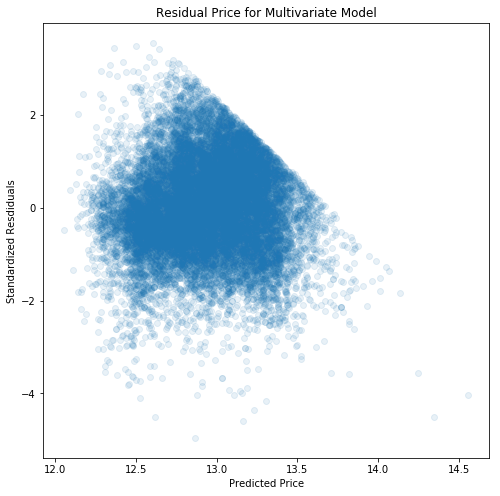

In [50]:
scaler = StandardScaler()
residuals = np.asarray(model.resid)
scaler.fit(residuals.reshape(-1,1))
standard_resid = scaler.transform(residuals.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Standardized Resdiduals')
plt.title('Residual Price for Multivariate Model')
_ = ax.scatter(model.predict(), standard_resid, alpha=0.1)

A QQ plot tells us if our residuals are normally distributed. Our residuals for the most part lay on the normal line with some curving at the tail. This means our extremes may have more values than a normal distribution and therefore the data is not completely normally distributed.

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


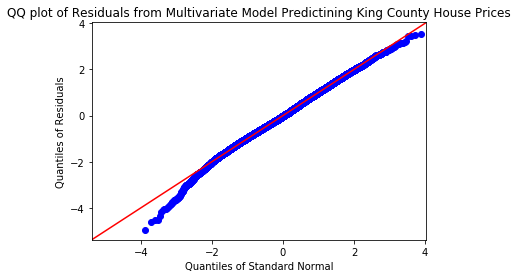

In [52]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.xlabel('Quantiles of Standard Normal')
plt.ylabel('Quantiles of Residuals')
plt.title('QQ plot of Residuals from Multivariate Model Predictining King County House Prices')
fig.show()

We will add one more factor to see if it improves the model further.

In [53]:
selector8 = RFE(linreg, n_features_to_select = 9)
selector8 = selector8.fit(house_data_90[predictors], house_data_90['log_price'])

sorted(list(zip(predictors, selector8.support_, selector8.ranking_)), key=lambda x: x[2])

[('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('floors', True, 1),
 ('waterfront', True, 1),
 ('view', True, 1),
 ('condition', True, 1),
 ('lat', True, 1),
 ('long', True, 1),
 ('distance_from_downtown_sea', True, 1),
 ('yr_built', False, 2),
 ('sqft_living', False, 3),
 ('sqft_basement', False, 4),
 ('sqft_lot', False, 5),
 ('sqft_lot15', False, 6),
 ('id', False, 7)]

In [54]:
X8 = ['bedrooms','bathrooms','floors','waterfront', 'view', 'condition', 'lat', 'long', 'distance_from_downtown_sea']
cv_8 = mae_for_kfolds(X8, y, house_data_90, 20)
train_errors = cv_8[0]
error_diffs = [train_error - test_error for (train_error, test_error) in list(zip(cv_8[0], cv_8[1]))]
np.mean(error_diffs), np.mean(train_errors)

(-199.8575626080892, 75535.23001400218)

This new model does show a decrease in the MAE to 75535.23 dollar and the error has also decreased. This tells us that the new model is probably a better predictor of price than the previous model. In the model summary we also see the features are statistically significant.

In [55]:
preds = house_data_90.loc[:, X8]
preds_int = sm.add_constant(preds)
model = sm.OLS(house_data_90['log_price'].values, preds_int).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     2489.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:29:36   Log-Likelihood:                -3021.6
No. Observations:               19381   AIC:                             6063.
Df Residuals:                   19371   BIC:                             6142.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         73.4440      3.274     22.430      0.000      67.026      79.862
bedrooms                       0.0482      0.003     18.533      0.000       0.043       0.053
bathrooms                      0.2070      0.004     52.212      0.000       0.199       0.215
floors                         0.0636      0.005     13.926      0.000       0.055       0.073
waterfront                     0.2968      0.047      6.358      0.000       0.205       0.388
view                           0.1194      0.004     32.862      0.000       0.112       0.126
condition                      0.0679      0.003     20.581      0.000       0.061       0.074
lat                            0.9251      0.020     45.180      0.000       0.885       0.965
long                           0.8603      0.022     38.894      0.000       0.817       0.904
distance_from_downtown_sea    -0.0236      0.001    -41.014      0.000      -0.025      -0.023
==============================================================================
Omnibus:                      256.284   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.678
Skew:                          -0.181   Prob(JB):                     5.25e-76
Kurtosis:                       3.546   Cond. No.                     2.12e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our residual plot does improve with the new model. The data points are scattered into a more even cloud.

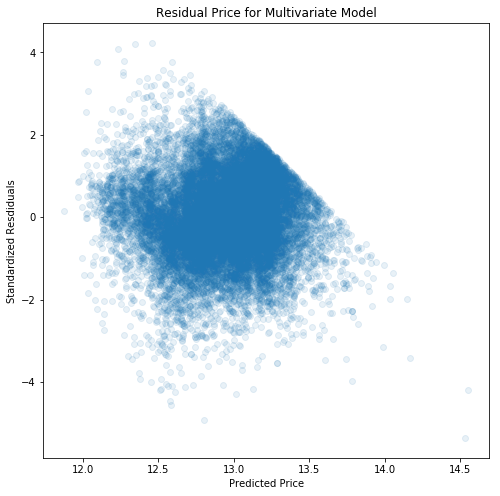

In [56]:
scaler = StandardScaler()
residuals = np.asarray(model.resid)
scaler.fit(residuals.reshape(-1,1))
standard_resid = scaler.transform(residuals.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,8))
plt.xlabel('Predicted Price')
plt.ylabel('Standardized Resdiduals')
plt.title('Residual Price for Multivariate Model')
_ = ax.scatter(model.predict(), standard_resid, alpha=0.1)

There are no major changes to the Q-Q plot. 

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


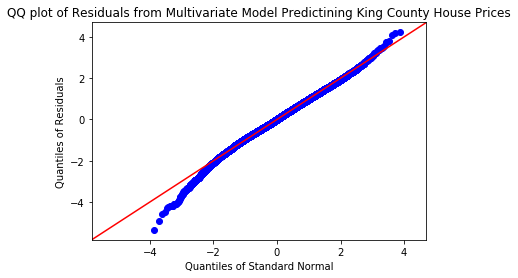

In [57]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
plt.xlabel('Quantiles of Standard Normal')
plt.ylabel('Quantiles of Residuals')
plt.title('QQ plot of Residuals from Multivariate Model Predictining King County House Prices')
fig.show()

## DEPLOYMENT

This is our formula from our final model that we can use to predict the price of a house in King County.

In [58]:
def predict_price(bed, bath, floors, waterfront, view, condition, lat, long, dist_from_sea):
    # these are the coefficients for each of the features provided in the model.
    log_price = (73.4440 + 0.0482*bed + 0.2070*bath + 0.0636*floors + 0.2986*waterfront
                 + 0.1194*view + 0.0679*condition + 0.9251*lat + 0.8603*long - 0.0236*dist_from_sea)
    price = np.exp(log_price)
    return price